# Задание 5. Извлечение данных 

## Задание 5.1

Напишите скрипт, который скачивает  сообщения с Телеграм-канала https://t.me/Sputnik_results . Сохраните сообщения в формате по вашему выбору (.csv, .jsonl, sqlite, parquet, и т.д.). Откройте с помощью Pandas или аналогичных библиотек, постройте график числа сообщений в зависимости от даты. 

#### Код скрипта для скачивания сообщений

In [ ]:
from telethon.sync import TelegramClient
from telethon.tl.functions.messages import GetHistoryRequest
import csv
 
api_id = ...
api_hash = "..."
phone = "..."
 
client = TelegramClient(phone, api_id, api_hash)
client.start()
 
offset_id = 0
limit = 100
all_messages = []
total_messages = 0
total_count_limit = 0
target_group = 'https://t.me/Sputnik_results'

print(target_group)
print("Производим парсинг сообщений в канале...") 
while True:
   history = client(GetHistoryRequest(
       peer=target_group,
       offset_id=offset_id,
       offset_date=None,
       add_offset=0,
       limit=limit,
       max_id=0,
       min_id=0,
       hash=0
   ))
   if not history.messages:
       break
   messages = history.messages

   for message in messages:
       all_messages.append(message)
   offset_id = messages[len(messages) - 1].id
   if total_count_limit != 0 and total_messages >= total_count_limit:
       break
  
print("Сохраняем данные в файл...")
with open("chats.csv", "w", encoding="UTF-8") as f:
   writer = csv.writer(f, delimiter=",", lineterminator="\n")
   writer.writerow(["date", "message"])  
   for message in all_messages:
        writer.writerow([message.date.date(), message.message])  
print('Парсинг сообщений группы успешно выполнен.')

#### Построение графика числа сообщений

In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [205]:
df = pd.read_csv('chats.csv').dropna()
df

,date,message
0,2022-12-29,Народные отчеты о вакцинации\n\n⚠️ ТОЛЬКО ПУБЛ...
1,2022-12-28,"Пол, возраст, наличие хр.заболеваний укажите, ..."
2,2022-12-27,Конвасэл до сих пор не даёт полноценный QR код...
3,2022-12-27,Dima32 Данный чат предназначен только для отчё...
4,2022-12-26,📣 ВЕСТНИК V1V2.ru выпуск #70 от 09.12.2022@09:...
...,...,...
31671,2020-12-09,"Есть примеры, уже появлялись"
31672,2020-12-09,Если денег не жалко
31673,2020-12-09,Не рано?
31674,2020-12-09,Через 2 недели обычно сдают


In [206]:
res = df.groupby('date').count()
res

,message
date,
2020-12-09,48
2020-12-10,29
2020-12-11,17
2020-12-12,5
2020-12-13,11
...,...
2022-12-25,1
2022-12-26,1
2022-12-27,2


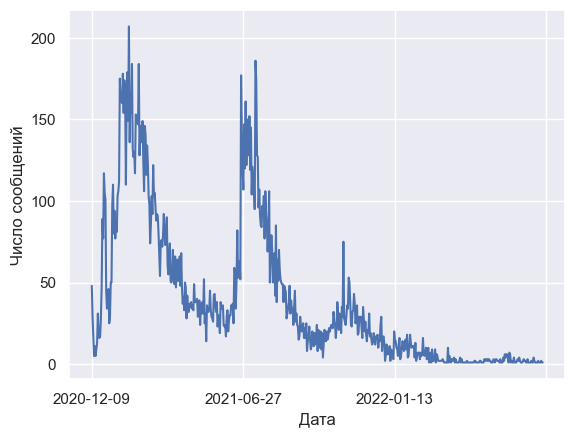

In [207]:
sns.set_theme()
res.plot()
plt.locator_params(axis='x', nbins=5)
plt.ylabel("Число сообщений")
plt.xlabel("Дата")
plt.legend().remove()


## Задание 5.2
1.Напишите функции для извлечения данных из сообщений:
   - пол участника
   - возраст участника

   Постройте диаграммы для визуализации. 

2.Реализуйте какой-либо анализ этих данных на ваше усмотрение. Например их можно кластеризовать и интерпретировать кластеры, или попробовать выделить статистику по среднему количеству антител в зависимости от возраста, или посчитать количество заболевших после вакцинации. Обязательна визуализация. 

#### Реализация функций для извлечения данных из сообщений

In [208]:
import regex as re

In [209]:
age = r'(\d{2})'
gender = r'([МмЖжД])(уж|ен)?(чина|щина)?'
pattern = re.compile(r'\b' + gender + r'\W{,3}' + age + r'|' + r'\b' + age + r'\W{,3}' + gender)

In [210]:
def get_gender_n_age(df):
    ages = []
    genders = []
    success = 0
    for mes in df['message']:
        result = pattern.search(mes)

        if result is not None:
            if result.group(1) is not None:
                ages.append(result.group(4))
                if result.group(1).upper() == "М":
                    genders.append("М")
                else:
                    genders.append("Ж")
            else:
                ages.append(result.group(5))
                if result.group(6).upper() == "М":
                    genders.append("М")
                else:
                    genders.append("Ж")
            success+=1
        else:
            ages.append(None)
            genders.append(None)

    return genders, ages

In [211]:
genders, ages = get_gender_n_age(df)
df2 = df.assign(gender=genders, age=ages)
df2 = df2.dropna()
df2

,date,message,gender,age
5,2022-12-25,#назально #ревак #спутник-V\nМ33. 1 комп.: лег...,М,33
7,2022-12-19,#назально #ревак. Ж35. Хр. Заболевания: полива...,Ж,35
9,2022-12-16,"#ревак #назально\n11.12.22. Гум, Спутник+Ультр...",Ж,45
10,2022-12-12,#дети\nМ 13 лет. спутник м. \n1я доза 23.10.2...,М,13
11,2022-12-09,#ревак #назально #спутник \nМ 49 вторая доза...,М,49
...,...,...,...,...
31476,2020-12-10,"В смысле ""пятым"" на флакон? В моем случае, дос...",М,15
31501,2020-12-10,Ж.47 Сутки после вакцинации (9.12.20). К ве...,Ж,47
31538,2020-12-10,М 48. Без симтомов. Тест на 30 день. вакцина 1...,М,48
31574,2020-12-09,М37. Первый компонент 03.12.2020 в 17:00. Чере...,М,37


Text(0, 0.5, 'Количество вакцинаций')

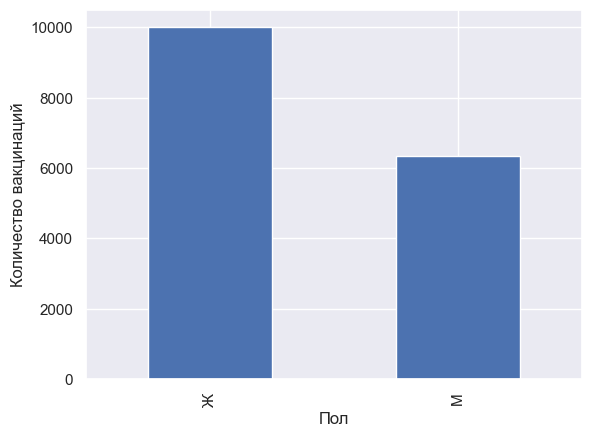

In [212]:
df2['gender'].value_counts().plot(kind='bar')
plt.xlabel("Пол")
plt.ylabel("Количество вакцинаций")

Text(0, 0.5, 'Количество вакцинаций')

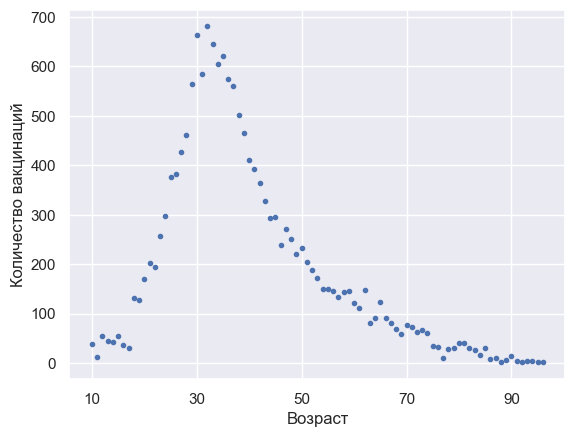

In [213]:
sns.set_theme()
df2['age'].value_counts().sort_index()[10:].plot(style=".")
plt.xlabel("Возраст")
plt.ylabel("Количество вакцинаций")

#### Определим средний уровень антител в зависимости от возраста привившихся

In [214]:
find_bau = re.compile(r'(\d+)[.,]?\d*\s+(BAU|bau|Bau|БАУ|бау|Бау)')

In [215]:
def average_bau(df):
    bau = []
    for mes in df['message']:
        result = find_bau.search(mes)
        if result is not None:
            bau.append(result.group(1))
        else:
            bau.append(None)
    return bau

In [216]:
all_bau = average_bau(df2)
df3 = df2.assign(BAU=all_bau)
df3 = df3.dropna()
df3

,date,message,gender,age,BAU
13,2022-12-04,"Дополняю и обобщаю:\n#ревак\nМоя мама\nЖ88, ди...",Ж,88,665
14,2022-12-04,"Еще дополняю и обобщаю\n#ревак #назально\nЖ51,...",Ж,51,313
26,2022-11-16,#ревак #назально #спутник\nЖ35\nПервая вакцина...,Ж,35,400
29,2022-11-08,"Еще дополняю и обобщаю\n#ревак #назально\nЖ51,...",Ж,51,313
34,2022-10-31,"#назально\n\nЖ43, в январе 2022 Омикрон без ПЦ...",Ж,43,3994
...,...,...,...,...,...
8999,2021-07-01,"Ж76, М75 (мои родители), без хронических забол...",Ж,76,138
9184,2021-06-30,"Ж18. 16 января - первый компонент Спутника, 7 ...",Ж,18,163
9190,2021-06-30,"Ж 24, ковидом не болела, хронических заболеван...",Ж,24,329
10582,2021-06-16,"БОЛГАРИЯ, Астразенека.\nЖ., 32 года\nV1 - 01.0...",Ж,32,530


In [218]:
df4 = df3[["age", "BAU"]]
df4 = df4.sort_values(by=['age'])
df4

,age,BAU
4533,08,25
4121,09,149
1533,10,97
1049,10,153
889,10,750
...,...,...
2036,85,806
2831,87,665
228,87,665
13,88,665


In [219]:
all_ages = []
all_bau = []
for age in df4['age'].values:
    all_ages.append(float(age))
for bau in df4['BAU'].values:
    all_bau.append(float(bau))    

In [220]:
splits = np.rint(np.linspace(all_ages[0], all_ages[-1], 12))
splits

array([ 8., 15., 23., 30., 38., 45., 53., 60., 68., 75., 83., 90.])

In [221]:
step = 0 
n = 0
cumsum = 0
avg_bau = []
for i in range(len(all_ages)):
    if all_ages[i] >= splits[step] and all_ages[i] < splits[step+1]:
        n+=1
        cumsum+=all_bau[i]
    else:
        avg_bau.append(cumsum/n)
        cumsum = 0
        n = 0
        step+=1

Text(0, 0.5, 'BAU')

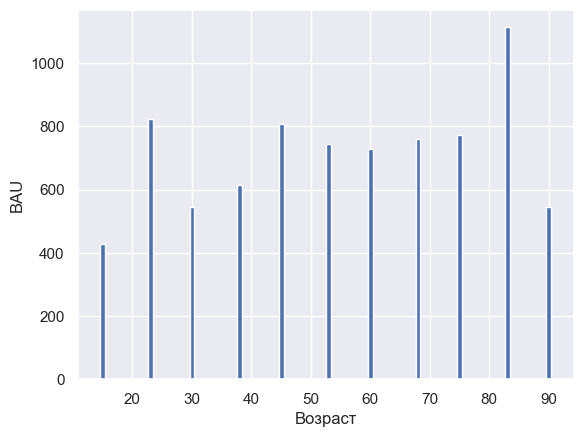

In [222]:
plt.bar(splits[1:], avg_bau)
plt.xlabel("Возраст")
plt.ylabel("BAU")